
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase1<br>
    Image Segmentation<br>
<font color=696880 size=4>
    Shayan Baghayi Nejad-Armin Khosravi


<font size=5 color=cyan> Names:Baran Hosseini / Raya jannat abady

Student Numbers:  </font>402170902 / 402105846

# Introduction

In this Project, we will become familiar with UNet architecture, Attention mechanism, and Residual blocks with the help of which we will build UNet, AttentionUNet, and ResidualAttentionUnet from scratch using PyTorch framework. The built models will be evaluated by various metrics such as accuracy, Iou score, and Dice score.

### Environment Setup

Here you will find the required packages. Feel free to add the list.

In [ ]:
import os
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import kagglehub
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm

# ابتدا حافظه را کاملاً پاک کنید
import gc
gc.collect()
torch.cuda.empty_cache()

# سپس device را تنظیم کنید
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print("مسیر فعلی:", os.getcwd())

# حالا حافظه را بررسی کنید
if torch.cuda.is_available():
    print(f"GPU Memory allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
    print(f"GPU Memory cached: {torch.cuda.memory_reserved()/1024**2:.2f} MB")

    # اگر هنوز حافظه اشغال شده، خطای واضح بدهید
    if torch.cuda.memory_allocated() > 10:  # بیشتر از 10 MB
        print("❌ خطا: حافظه GPU هنوز پر است!")
    else:
        print("✅ حافظه GPU آماده است")

cuda
مسیر فعلی: /content
GPU Memory allocated: 0.00 MB
GPU Memory cached: 0.00 MB
✅ حافظه GPU آماده است


### Hyperparameter Setting

Place your hyperparameters' values in the cell below.

In [9]:
DATA_DIR = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 4
NUM_WORKERS = 0
LR = 0.001
NUM_EPOCHS = 15


Using Colab cache for faster access to the 'massachusetts-roads-dataset' dataset.


# Data Preparation

Our task is to segment the [Massachusetts Road Dataset](https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset). You can download this dataset by placing your API Token from kaggle in ```~/.kaggle/``` folder (Instructions can be found in the Kaggle website) and then running the code below.

In [5]:
path = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")

print("Path to dataset files:", path)

Download already complete (6189402258 bytes).
Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/balraj98/massachusetts-roads-dataset/versions/1


If you are running on colab, it is highly recommended to save the dataset to your drive to avoid problems when disconnecting from runtime.

In [7]:
from google.colab import drive

dst = '/content/drive/MyDrive/massachusetts-roads-dataset'

if not os.path.exists(dst):
    shutil.move(path, dst)
else:
    print("Dataset already exists in Google Drive:", dst)

Dataset already exists in Google Drive: /content/drive/MyDrive/massachusetts-roads-dataset


### Loading Images

Load the images and their corresponding masks in two separate lists. (The cell below might take some time to execute.)

In [10]:
def load_images_and_masks(images_path, masks_path, image_size):
    images = []
    masks = []

    image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.tiff')])
    mask_files  = sorted([f for f in os.listdir(masks_path) if f.endswith('.tif')])

    image_names = [os.path.splitext(f)[0] for f in image_files]
    mask_names  = [os.path.splitext(f)[0] for f in mask_files]

    common_names = set(image_names) & set(mask_names)

    for name in common_names:
        img_path  = os.path.join(images_path, f"{name}.tiff")
        mask_path = os.path.join(masks_path, f"{name}.tif")

        img  = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        img  = img.resize(image_size)
        mask = mask.resize(image_size)

        images.append(np.array(img) / 255.0)

       
        mask_array = np.array(mask)
        mask_array = (mask_array > 128).astype(np.float32)  # باینری کردن
        masks.append(mask_array)

    return np.array(images), np.array(masks)


# Define training image and mask directories
train_images_dir = os.path.join(DATA_DIR, 'tiff/train')
train_masks_dir  = os.path.join(DATA_DIR, 'tiff/train_labels')

# Get paths or filenames for training images and masks
train_images_path = train_images_dir
train_masks_path  = train_masks_dir

# Load and preprocess training images and masks
train_images, train_masks = load_images_and_masks(train_images_path, train_masks_path, IMAGE_SIZE)

# Print lengths to confirm data loaded correctly
print(f"Number of training images: {len(train_images)}")
print(f"Number of training masks: {len(train_masks)}")


Number of training images: 1108
Number of training masks: 1108


### Data Visualization

Display the images and their masks for several samples.

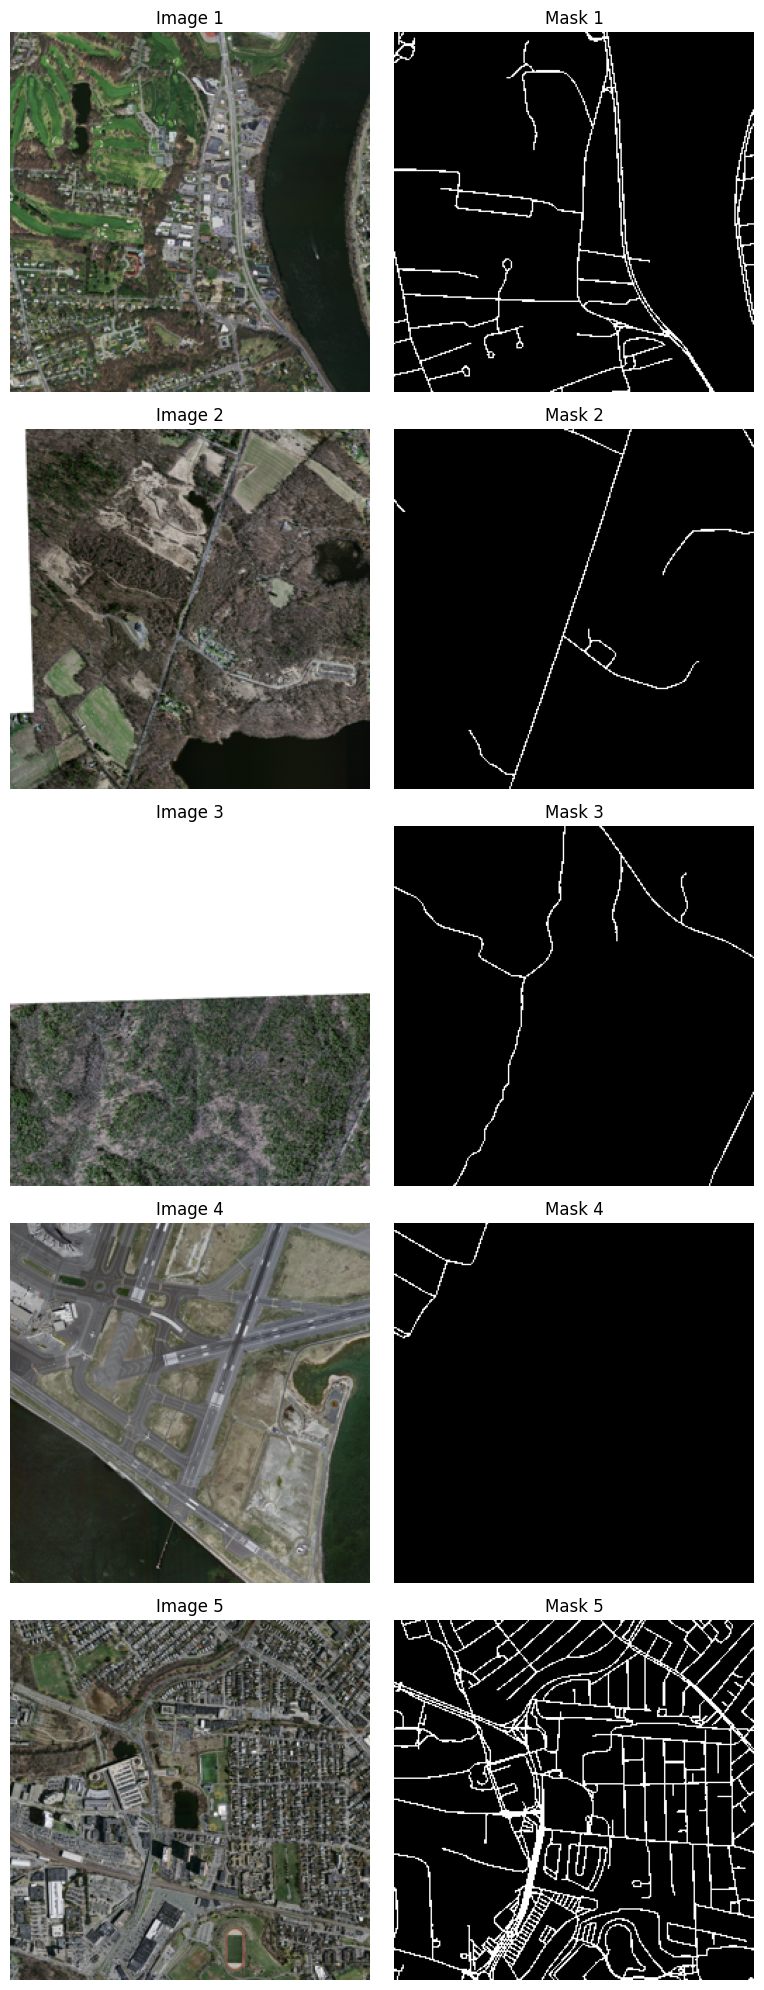

In [11]:
def visualize_images_and_masks(images, masks, n=5):
    """
    Visualizes 'n' images and their corresponding masks side by side.

    Args:
        images (array-like): Collection of input images.
        masks (array-like): Collection of corresponding mask images.
        n (int): Number of image-mask pairs to display.
    """
    plt.figure(figsize=(8, 4 * n))

    for i in range(n):
        # نمایش تصویر اصلی
        plt.subplot(n, 2, 2*i + 1)
        plt.imshow(images[i])
        plt.title(f"Image {i+1}")
        plt.axis('off')

        # نمایش ماسک متناظر
        plt.subplot(n, 2, 2*i + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title(f"Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_images_and_masks(train_images, train_masks, n=5)

### Dataset Creation

Finally, we will make the dataset using the list of images we have stored.

In [ ]:
# ===============================
# Load validation images and masks
# ===============================
val_images_dir = os.path.join(DATA_DIR, 'tiff/val')
val_masks_dir  = os.path.join(DATA_DIR, 'tiff/val_labels')

val_images, val_masks = load_images_and_masks(val_images_dir, val_masks_dir, IMAGE_SIZE)

# ===============================
# Define the Dataset class
# ===============================
class RoadDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask  = self.masks[idx]

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # مطمئن شوید mask باینری است
        if isinstance(mask, torch.Tensor):
            mask = (mask > 0.5).float()
        else:
            mask = torch.from_numpy((mask > 0.5).astype(np.float32))

        if mask.ndim == 2:
            mask = mask.unsqueeze(0)  # اضافه کردن کانال

        return image, mask
# ===============================
# Define transformations
# ===============================
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),

])

# ===============================
# Create datasets
# ===============================
train_dataset = RoadDataset(train_images, train_masks, image_transform, mask_transform)
val_dataset   = RoadDataset(val_images, val_masks, image_transform, mask_transform)

# ===============================
# Create data loaders
# ===============================
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader    = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

for images, masks in train_loader:
    print(f"Images device: {images.device}")
    print(f"Masks device: {masks.device}")
    print(f"Unique mask values: {torch.unique(masks)}")
    break


# UNet

Before proceeding, it is necessary to understand the idea behind UNet. In order to avoid too much details in this notebook, you can read the complete paper for UNet from [this link](https://arxiv.org/pdf/1505.04597).

The overall structure of UNet is provided in the image below.

![UNet Architecture](https://viso.ai/wp-content/uploads/2024/04/unet-process.png)

### Convolution Block

Convolution block is used at each level of UNet.

In [ ]:
class ConvBlock(nn.Module):

    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

### Up Convoluitional Block

We use another block to upsample the latent vector.

In [ ]:
class UpConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.upconv(x)

### Complete UNet Structure

Now using the ```ConvBlock``` and ```UpConvBlock``` you created, complete the UNet architecture.

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channel=3, out_channel=1, filters=[64, 128, 256, 512]):
        super().__init__()

        # Encoder
        self.enc1 = ConvBlock(in_channel, filters[0])
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(filters[0], filters[1])
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(filters[1], filters[2])
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(filters[2], filters[3])
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(filters[3], filters[3] * 2)

        # Decoder
        self.up4 = UpConvBlock(filters[3] * 2, filters[3])
        self.dec4 = ConvBlock(filters[3] * 2, filters[3])  # توجه: filters[3]*2 نه filters[3]*2

        self.up3 = UpConvBlock(filters[3], filters[2])
        self.dec3 = ConvBlock(filters[2] * 2, filters[2])  # تصحیح شده

        self.up2 = UpConvBlock(filters[2], filters[1])
        self.dec2 = ConvBlock(filters[1] * 2, filters[1])  # تصحیح شده

        self.up1 = UpConvBlock(filters[1], filters[0])
        self.dec1 = ConvBlock(filters[0] * 2, filters[0])  # تصحیح شده

        # Output
        self.conv_out = nn.Conv2d(filters[0], out_channel, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)        # [B, 64, H, W]
        e2 = self.enc2(self.pool1(e1))  # [B, 128, H/2, W/2]
        e3 = self.enc3(self.pool2(e2))  # [B, 256, H/4, W/4]
        e4 = self.enc4(self.pool3(e3))  # [B, 512, H/8, W/8]

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))  # [B, 1024, H/16, W/16]

        # Decoder
        d4 = self.up4(b)          # [B, 512, H/8, W/8]
        d4 = torch.cat([e4, d4], dim=1)  # [B, 1024, H/8, W/8]
        d4 = self.dec4(d4)        # [B, 512, H/8, W/8]

        d3 = self.up3(d4)         # [B, 256, H/4, W/4]
        d3 = torch.cat([e3, d3], dim=1)  # [B, 512, H/4, W/4]
        d3 = self.dec3(d3)        # [B, 256, H/4, W/4]

        d2 = self.up2(d3)         # [B, 128, H/2, W/2]
        d2 = torch.cat([e2, d2], dim=1)  # [B, 256, H/2, W/2]
        d2 = self.dec2(d2)        # [B, 128, H/2, W/2]

        d1 = self.up1(d2)         # [B, 64, H, W]
        d1 = torch.cat([e1, d1], dim=1)  # [B, 128, H, W]
        d1 = self.dec1(d1)        # [B, 64, H, W]

        out = self.conv_out(d1)   # [B, 1, H, W]
        out = self.sigmoid(out)
        return out

# Attention UNet

### Attention Mechanism

Attention UNet uses this mechanism to know what part the image is more important to attend to. You can read about this mechanism from [this link](https://arxiv.org/pdf/1706.03762). The Attention mechanism in UNet is described in [this paper](https://arxiv.org/pdf/1804.03999).


![Attention](https://www.researchgate.net/publication/373655981/figure/fig3/AS:11431281186315360@1693879045519/Visualization-of-attention-blocks-reveals-their-functionality-While-the-self-attention.png)

In [ ]:
class AttentionBlock(nn.Module):
    """
    Attention block for focusing on relevant features in skip connections.

    Args:
        f_g (int): Number of channels in the gating signal (from decoder).
        f_l (int): Number of channels in the skip connection input (from encoder).
        f_int (int): Number of intermediate channels used within the attention block.
    """
    def __init__(self, f_g, f_l, f_int):
        super().__init__()

        self.w_g = nn.Sequential(
            nn.Conv2d(f_g, f_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(f_int)
        )

        self.w_x = nn.Sequential(
            nn.Conv2d(f_l, f_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(f_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(f_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.act = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.act(g1 + x1)
        psi = self.psi(psi)
        return x * psi


Now use the ```AttentionBlock``` to inherit [Attention UNet](https://arxiv.org/pdf/1804.03999) from UNet.

![Attention UNet](https://www.researchgate.net/publication/347344899/figure/fig6/AS:971357475069952@1608601077414/The-architecture-of-Attention-U-Net-Attention-gate-selects-features-by-using-the.png)

In [ ]:
class AttentionUNet(nn.Module):
    """
    Attention U-Net architecture which extends the basic U-Net
    by integrating attention blocks in the skip connections.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
        filter_sizes (list): List of filter sizes for each level.
    """
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64, 128, 256, 512]):
        super().__init__()

        # Encoder
        self.conv1 = ConvBlock(in_channel, filter_sizes[0])
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = ConvBlock(filter_sizes[0], filter_sizes[1])
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = ConvBlock(filter_sizes[1], filter_sizes[2])
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = ConvBlock(filter_sizes[2], filter_sizes[3])
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(filter_sizes[3], filter_sizes[3]*2)

        # Decoder
        self.upconv4 = UpConvBlock(filter_sizes[3]*2, filter_sizes[3])
        self.dec4 = ConvBlock(filter_sizes[3]*2, filter_sizes[3])

        self.upconv3 = UpConvBlock(filter_sizes[3], filter_sizes[2])
        self.dec3 = ConvBlock(filter_sizes[2]*2, filter_sizes[2])

        self.upconv2 = UpConvBlock(filter_sizes[2], filter_sizes[1])
        self.dec2 = ConvBlock(filter_sizes[1]*2, filter_sizes[1])

        self.upconv1 = UpConvBlock(filter_sizes[1], filter_sizes[0])
        self.dec1 = ConvBlock(filter_sizes[0]*2, filter_sizes[0])

        # Output
        self.conv_out = nn.Conv2d(filter_sizes[0], out_channel, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

        # Attention blocks
        self.att3 = AttentionBlock(f_g=filter_sizes[2], f_l=filter_sizes[2], f_int=filter_sizes[2]//2)
        self.att2 = AttentionBlock(f_g=filter_sizes[1], f_l=filter_sizes[1], f_int=filter_sizes[1]//2)
        self.att1 = AttentionBlock(f_g=filter_sizes[0], f_l=filter_sizes[0], f_int=filter_sizes[0]//2)

    def forward(self, x):
        # Encoder
        e1 = self.conv1(x)
        e2 = self.conv2(self.pool1(e1))
        e3 = self.conv3(self.pool2(e2))
        e4 = self.conv4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder with attention
        d4 = self.upconv4(b)
        d4 = torch.cat([e4, d4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        e3 = self.att3(d3, e3)  # attention روی skip connection
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        e2 = self.att2(d2, e2)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        e1 = self.att1(d1, e1)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.conv_out(d1)
        out = self.sigmoid(out)
        return out


# Residual Attention UNet

We will add residual blocks to the attention for better gradient flow. You can read more about residual blocks [here](https://arxiv.org/pdf/1512.03385).

<img src="https://dfzljdn9uc3pi.cloudfront.net/2023/cs-1302/1/fig-1-full.png" width="400" alt="ResUNet Architecture">

In [ ]:
class ResidualConvBlock(nn.Module):
    """
    Residual convolutional block with skip connection.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel)
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channel)
        ) if in_channel != out_channel else nn.Identity()

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.conv2(out)
        out += identity
        out = self.relu(out)
        return out


Use ```ResidualConvBlock``` to construct Residual Attention Unet.

In [ ]:
class ResidualAttentionUNet(AttentionUNet):
    """
    Residual Attention U-Net combining residual blocks with attention mechanisms.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
        filter_sizes (list): List of filter sizes for each level.
    """
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64, 128, 256, 512]):
        super().__init__(in_channel, out_channel, filter_sizes)

        # Encoder (residual blocks)
        self.conv1 = ResidualConvBlock(in_channel, filter_sizes[0])
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = ResidualConvBlock(filter_sizes[0], filter_sizes[1])
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = ResidualConvBlock(filter_sizes[1], filter_sizes[2])
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = ResidualConvBlock(filter_sizes[2], filter_sizes[3])
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ResidualConvBlock(filter_sizes[3], filter_sizes[3]*2)

        # Decoder
        self.upconv4 = UpConvBlock(filter_sizes[3]*2, filter_sizes[3])
        self.dec4 = ResidualConvBlock(filter_sizes[3]*2, filter_sizes[3])

        self.upconv3 = UpConvBlock(filter_sizes[3], filter_sizes[2])
        self.dec3 = ResidualConvBlock(filter_sizes[2]*2, filter_sizes[2])

        self.upconv2 = UpConvBlock(filter_sizes[2], filter_sizes[1])
        self.dec2 = ResidualConvBlock(filter_sizes[1]*2, filter_sizes[1])

        self.upconv1 = UpConvBlock(filter_sizes[1], filter_sizes[0])
        self.dec1 = ResidualConvBlock(filter_sizes[0]*2, filter_sizes[0])

        # Output
        self.conv_out = nn.Conv2d(filter_sizes[0], out_channel, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

        # Attention blocks (چهارتا لازمه!)
        self.att4 = AttentionBlock(f_g=filter_sizes[3], f_l=filter_sizes[3], f_int=filter_sizes[3]//2)
        self.att3 = AttentionBlock(f_g=filter_sizes[2], f_l=filter_sizes[2], f_int=filter_sizes[2]//2)
        self.att2 = AttentionBlock(f_g=filter_sizes[1], f_l=filter_sizes[1], f_int=filter_sizes[1]//2)
        self.att1 = AttentionBlock(f_g=filter_sizes[0], f_l=filter_sizes[0], f_int=filter_sizes[0]//2)

    def forward(self, x):
        # Encoder
        e1 = self.conv1(x)
        e2 = self.conv2(self.pool1(e1))
        e3 = self.conv3(self.pool2(e2))
        e4 = self.conv4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder + Attention
        d4 = self.upconv4(b)
        e4 = self.att4(d4, e4)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        e3 = self.att3(d3, e3)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        e2 = self.att2(d2, e2)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        e1 = self.att1(d1, e1)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.conv_out(d1)
        out = self.sigmoid(out)
        return out


# Training

Now it is time to train the model on training data.

### Loss Function

We will be using the sum of [Dice Score](https://oecd.ai/en/catalogue/metrics/dice-score#:~:text=The%20Dice%20score%20is%20calculated,sizes%20of%20the%20two%20sets.), [Iou Score](https://www.v7labs.com/blog/intersection-over-union-guide), and Binary Cross Entropy as loss function. You can read about the mentioned scores in the provided links.

<font color=cyan><b> Note: Do Not Change The ```OverallLoss``` Function as it is used for measuring you model's performance.</b></font>

In [ ]:
import torch
import torch.nn as nn

### DICE LOSS
class DiceLoss(nn.Module):
    """
    Dice Loss for measuring overlap between predicted and ground truth masks.
    Particularly useful for imbalanced classes in segmentation tasks.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        pred_flat = pred.view(pred.size(0), -1)
        real_flat = real.view(real.size(0), -1)
        intersection = (pred_flat * real_flat).sum(dim=1)
        dice_coeff = (2.0 * intersection + self.smooth) / (pred_flat.sum(dim=1) + real_flat.sum(dim=1) + self.smooth)
        return 1-dice_coeff.mean()


### Iou Loss
class IouLoss(nn.Module):
    """
    Intersection over Union (IoU) Loss for segmentation evaluation.
    Measures the overlap between predicted and ground truth masks.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(IouLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        pred_flat = pred.view(pred.size(0), -1)
        real_flat = real.view(real.size(0), -1)
        intersection = (pred_flat * real_flat).sum(dim=1)
        union = pred_flat.sum(dim=1) + real_flat.sum(dim=1) - intersection
        iou_coeff = (intersection + self.smooth) / (union + self.smooth)
        return 1-iou_coeff.mean()


### Overall Loss (DO NOT CHANGE)
class OverallLoss(nn.Module):
    """
    Combined loss function that sums Dice loss, IoU loss, and Binary Cross-Entropy loss.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(OverallLoss, self).__init__()
        self.dice_loss = DiceLoss(smooth)
        self.iou_loss = IouLoss(smooth)
        self.bce_loss = nn.BCELoss()

    def forward(self, pred, real):
        dice = self.dice_loss(pred, real)
        iou = self.iou_loss(pred, real)
        bce = self.bce_loss(pred, real)

        return dice, iou, bce, dice+iou+bce


### Training Epoch

Complete the function below to train the model for one epoch.

In [ ]:
import torch
from tqdm import tqdm

def train_one_epoch(model, optimizer, criterion, data_loader, scheduler=None, device=device):
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The neural network model to train.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        criterion (nn.Module): Loss function to compute the loss.
        data_loader (DataLoader): DataLoader providing training batches.
        scheduler (optional): Learning rate scheduler.
        device (str): Device to run the training on ('cuda' or 'cpu').

    Returns:
        float: Average loss over the epoch.
    """

    total_loss = 0.0
    model.train()
    for i, (img, mask) in enumerate(tqdm(data_loader)):
        # Move the image and mask to device
        img = img.to(device, dtype=torch.float)
        mask = mask.to(device, dtype=torch.float)

        # Set the gradients to zero
        optimizer.zero_grad()

        # Predict the mask using the model
        pred = model(img)

        # Compute the loss
        _, _, _, loss = criterion(pred, mask)

        # Compute gradients
        loss.backward()

        # Update the parameters
        optimizer.step()

        if scheduler:
            # Schedule the learning rate
            scheduler.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


Design a function for evaluation after each training phase.

# Model Training

### UNet  
Create an instance of UNet and train it. Then report the results.  

<b><font color=red>Note: your models need to satisfy below conditions to get complete score.</font></b>

<table style="width: 100%; font-size: 18px; border-collapse: collapse; margin: 15px 0;">
  <tr>
    <th style="text-align: left; padding: 8px; border-bottom: 2px solid #ddd;">Model</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Validation Loss</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Iou Score</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Dice Score</th>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 1.0</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.5</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">Attention UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 0.9</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.65</td>
  </tr>
  <tr>
    <td style="padding: 8px;">Residual Attention UNet</td>
    <td style="text-align: right; padding: 8px;">&lt; 0.8</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.65</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.7</td>
  </tr>
</table>

In [ ]:
unet = UNet().to(device)
criterion = OverallLoss()
optimizer = Adam(unet.parameters(), lr=LR)

train_losses_u = []
val_losses_u = []
iou_scores_u = []
dice_scores_u = []

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(unet, criterion, val_loader)

    train_losses_u.append(train_loss)
    val_losses_u.append(val_loss)
    iou_scores_u.append(iou_score)
    dice_scores_u.append(dice_score)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(unet.state_dict(), "best_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 4/4 [00:00<00:00, 16.45it/s]


Iteration 1/15: Train Loss: 1.59 | Val Loss: 1.09 | Iou Score: 0.50 | Dice Score: 0.67


100%|██████████| 4/4 [00:00<00:00, 15.57it/s]


Iteration 2/15: Train Loss: 1.20 | Val Loss: 0.95 | Iou Score: 0.57 | Dice Score: 0.72


100%|██████████| 4/4 [00:00<00:00, 14.36it/s]


Iteration 3/15: Train Loss: 1.12 | Val Loss: 0.98 | Iou Score: 0.57 | Dice Score: 0.72


100%|██████████| 4/4 [00:00<00:00, 13.83it/s]


Iteration 4/15: Train Loss: 1.09 | Val Loss: 0.89 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00, 13.73it/s]


Iteration 5/15: Train Loss: 1.05 | Val Loss: 0.84 | Iou Score: 0.61 | Dice Score: 0.76


100%|██████████| 4/4 [00:00<00:00, 13.84it/s]


Iteration 6/15: Train Loss: 1.04 | Val Loss: 0.84 | Iou Score: 0.61 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00, 13.95it/s]


Iteration 7/15: Train Loss: 1.02 | Val Loss: 0.89 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00, 14.09it/s]


Iteration 8/15: Train Loss: 1.00 | Val Loss: 0.82 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 4/4 [00:00<00:00, 14.48it/s]


Iteration 9/15: Train Loss: 0.99 | Val Loss: 0.84 | Iou Score: 0.62 | Dice Score: 0.76


100%|██████████| 4/4 [00:00<00:00, 14.26it/s]


Iteration 10/15: Train Loss: 1.00 | Val Loss: 0.81 | Iou Score: 0.62 | Dice Score: 0.77


100%|██████████| 4/4 [00:00<00:00, 14.30it/s]


Iteration 11/15: Train Loss: 0.98 | Val Loss: 0.79 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 4/4 [00:00<00:00, 14.21it/s]


Iteration 12/15: Train Loss: 0.96 | Val Loss: 0.82 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 4/4 [00:00<00:00, 14.12it/s]


Iteration 13/15: Train Loss: 0.95 | Val Loss: 0.79 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 4/4 [00:00<00:00, 14.33it/s]


Iteration 14/15: Train Loss: 0.96 | Val Loss: 0.78 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 4/4 [00:00<00:00, 14.34it/s]


Iteration 15/15: Train Loss: 0.94 | Val Loss: 0.77 | Iou Score: 0.64 | Dice Score: 0.78


Now do the same for Attention UNet and Reidual Attention UNet.

In [ ]:
attention_unet = AttentionUNet().to(device)
criterion = OverallLoss()
optimizer = Adam(attention_unet.parameters(), lr=LR)

train_losses_a = []
val_losses_a = []
iou_scores_a = []
dice_scores_a = []

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(attention_unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(attention_unet, criterion, val_loader)

    train_losses_a.append(train_loss)
    val_losses_a.append(val_loss)
    iou_scores_a.append(iou_score)
    dice_scores_a.append(dice_score)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(attention_unet.state_dict(), "best_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 4/4 [00:00<00:00, 10.06it/s]


Iteration 1/15: Train Loss: 1.56 | Val Loss: 1.06 | Iou Score: 0.52 | Dice Score: 0.68


100%|██████████| 4/4 [00:00<00:00, 15.39it/s]


Iteration 2/15: Train Loss: 1.21 | Val Loss: 0.98 | Iou Score: 0.55 | Dice Score: 0.71


100%|██████████| 4/4 [00:00<00:00, 14.24it/s]


Iteration 3/15: Train Loss: 1.13 | Val Loss: 0.91 | Iou Score: 0.58 | Dice Score: 0.73


100%|██████████| 4/4 [00:00<00:00, 13.72it/s]


Iteration 4/15: Train Loss: 1.09 | Val Loss: 0.98 | Iou Score: 0.56 | Dice Score: 0.71


100%|██████████| 4/4 [00:00<00:00, 13.14it/s]


Iteration 5/15: Train Loss: 1.06 | Val Loss: 0.84 | Iou Score: 0.62 | Dice Score: 0.76


100%|██████████| 4/4 [00:00<00:00, 13.04it/s]


Iteration 6/15: Train Loss: 1.05 | Val Loss: 0.89 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00, 12.99it/s]


Iteration 7/15: Train Loss: 1.04 | Val Loss: 0.89 | Iou Score: 0.60 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00, 13.03it/s]


Iteration 8/15: Train Loss: 1.03 | Val Loss: 0.85 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 4/4 [00:00<00:00, 12.85it/s]


Iteration 9/15: Train Loss: 1.01 | Val Loss: 0.85 | Iou Score: 0.62 | Dice Score: 0.76


100%|██████████| 4/4 [00:00<00:00, 13.14it/s]


Iteration 10/15: Train Loss: 1.01 | Val Loss: 0.81 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 4/4 [00:00<00:00, 12.87it/s]


Iteration 11/15: Train Loss: 0.99 | Val Loss: 0.89 | Iou Score: 0.61 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00, 12.78it/s]


Iteration 12/15: Train Loss: 0.99 | Val Loss: 0.92 | Iou Score: 0.59 | Dice Score: 0.74


100%|██████████| 4/4 [00:00<00:00, 13.18it/s]


Iteration 13/15: Train Loss: 0.98 | Val Loss: 0.78 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 4/4 [00:00<00:00, 12.93it/s]


Iteration 14/15: Train Loss: 0.97 | Val Loss: 0.81 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 4/4 [00:00<00:00, 11.58it/s]

Iteration 15/15: Train Loss: 0.98 | Val Loss: 0.84 | Iou Score: 0.62 | Dice Score: 0.76


For Residual Attention UNet, plot the changes in train and validation loss.

In [ ]:
resattn_unet = ResidualAttentionUNet().to(device)
criterion = OverallLoss()

optimizer = Adam(resattn_unet.parameters(), lr=LR)
train_losses_r = []
val_losses_r = []
iou_scores_r = []
dice_scores_r = []

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(resattn_unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(resattn_unet, criterion, val_loader)

    train_losses_r.append(train_loss)
    val_losses_r.append(val_loss)
    iou_scores_r.append(iou_score)
    dice_scores_r.append(dice_score)

    if val_loss < best_loss:
        torch.save(resattn_unet.state_dict(), "best_residual_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 4/4 [00:00<00:00, 11.89it/s]


Iteration 1/15: Train Loss: 1.57 | Val Loss: 1.18 | Iou Score: 0.47 | Dice Score: 0.63


100%|██████████| 4/4 [00:00<00:00, 13.67it/s]


Iteration 2/15: Train Loss: 1.22 | Val Loss: 1.00 | Iou Score: 0.56 | Dice Score: 0.72


100%|██████████| 4/4 [00:00<00:00, 12.30it/s]


Iteration 3/15: Train Loss: 1.13 | Val Loss: 0.93 | Iou Score: 0.58 | Dice Score: 0.73


100%|██████████| 4/4 [00:00<00:00, 11.14it/s]


Iteration 4/15: Train Loss: 1.08 | Val Loss: 0.87 | Iou Score: 0.61 | Dice Score: 0.76


100%|██████████| 4/4 [00:00<00:00, 10.40it/s]


Iteration 5/15: Train Loss: 1.05 | Val Loss: 0.86 | Iou Score: 0.61 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00,  9.57it/s]


Iteration 6/15: Train Loss: 1.02 | Val Loss: 0.82 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 4/4 [00:00<00:00, 11.39it/s]


Iteration 7/15: Train Loss: 1.01 | Val Loss: 0.84 | Iou Score: 0.61 | Dice Score: 0.75


100%|██████████| 4/4 [00:00<00:00, 11.78it/s]


Iteration 8/15: Train Loss: 0.99 | Val Loss: 0.79 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 4/4 [00:00<00:00, 12.24it/s]


Iteration 9/15: Train Loss: 0.97 | Val Loss: 0.77 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 4/4 [00:00<00:00, 12.22it/s]


Iteration 10/15: Train Loss: 0.98 | Val Loss: 0.84 | Iou Score: 0.62 | Dice Score: 0.76


100%|██████████| 4/4 [00:00<00:00, 11.51it/s]


Iteration 11/15: Train Loss: 0.95 | Val Loss: 0.78 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 4/4 [00:00<00:00, 12.15it/s]


Iteration 12/15: Train Loss: 0.95 | Val Loss: 0.83 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 4/4 [00:00<00:00, 12.34it/s]


Iteration 13/15: Train Loss: 0.93 | Val Loss: 0.81 | Iou Score: 0.63 | Dice Score: 0.77


100%|██████████| 4/4 [00:00<00:00, 12.03it/s]


Iteration 14/15: Train Loss: 0.93 | Val Loss: 0.79 | Iou Score: 0.64 | Dice Score: 0.78


100%|██████████| 4/4 [00:00<00:00, 11.83it/s]


Iteration 15/15: Train Loss: 0.91 | Val Loss: 0.79 | Iou Score: 0.64 | Dice Score: 0.78


Now Visualize losses.

the following 2 curves are results for UNet architecture:
the following 2 curves are results for Attention-UNet architecture:
the following 2 curves are results for Residual-Attention-UNet architecture:



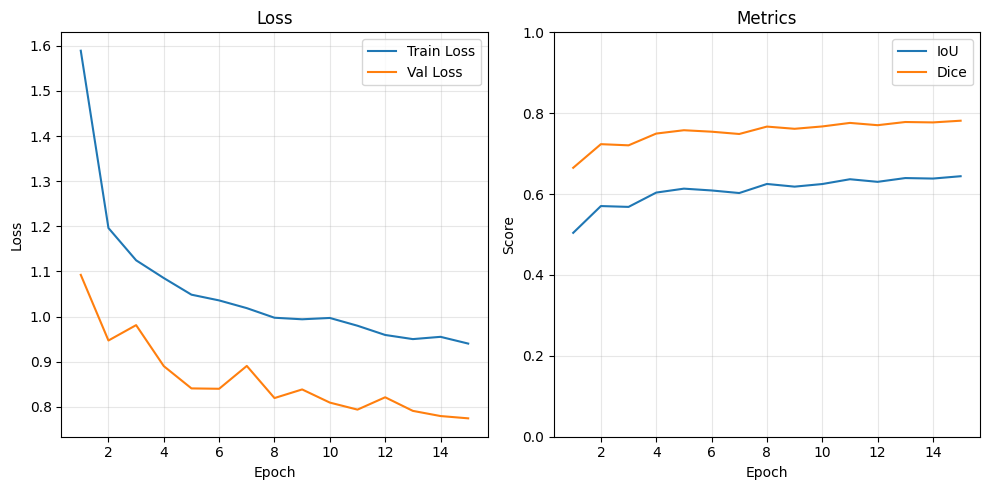

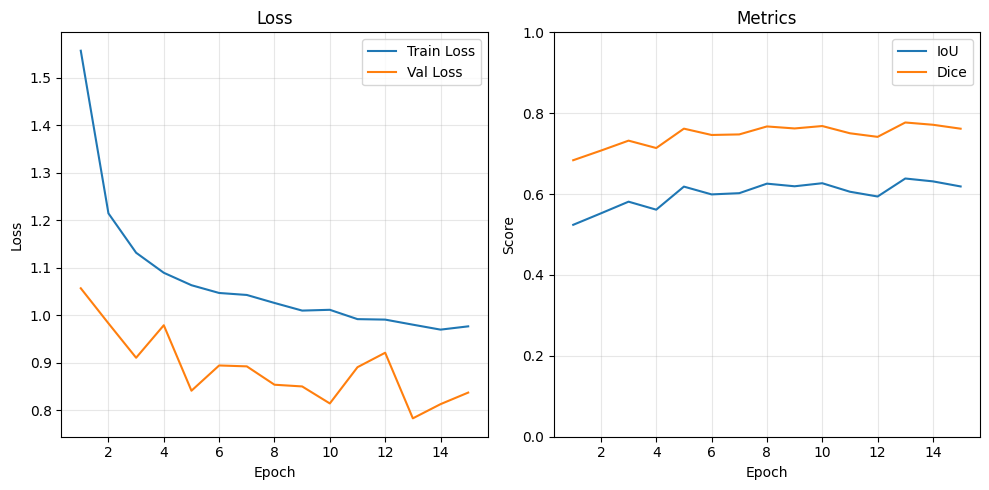

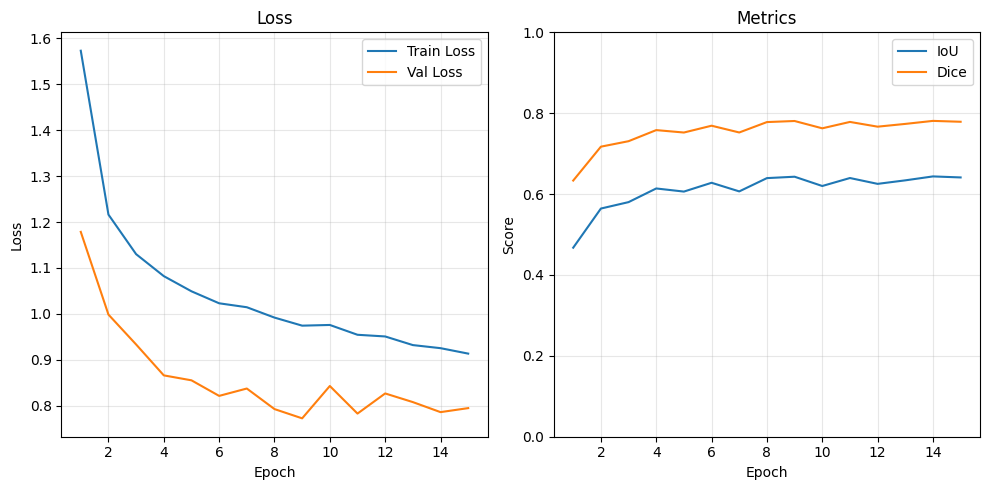

In [ ]:
def plot_training_curves(train_losses, val_losses, ious, dices):

    epochs = range(1, len(train_losses) + 1)
    fig = plt.figure(figsize=(10, 5))

    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(epochs, train_losses, label='Train Loss')
    ax1.plot(epochs, val_losses,   label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(epochs, ious, label='IoU')
    ax2.plot(epochs, dices, label='Dice')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.set_ylim(0, 1)
    ax2.set_title('Metrics')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    plt.tight_layout()

    return fig

print("the following 2 curves are results for UNet architecture:")
plot_training_curves(train_losses_u, val_losses_u, iou_scores_u, dice_scores_u)
print("the following 2 curves are results for Attention-UNet architecture:")
plot_training_curves(train_losses_a, val_losses_a, iou_scores_a, dice_scores_a)
print("the following 2 curves are results for Residual-Attention-UNet architecture:")
plot_training_curves(train_losses_r, val_losses_r, iou_scores_r, dice_scores_r)
print("")

### Prediction Visualisation

Display several images, their masks, and the predicted mask by your model.

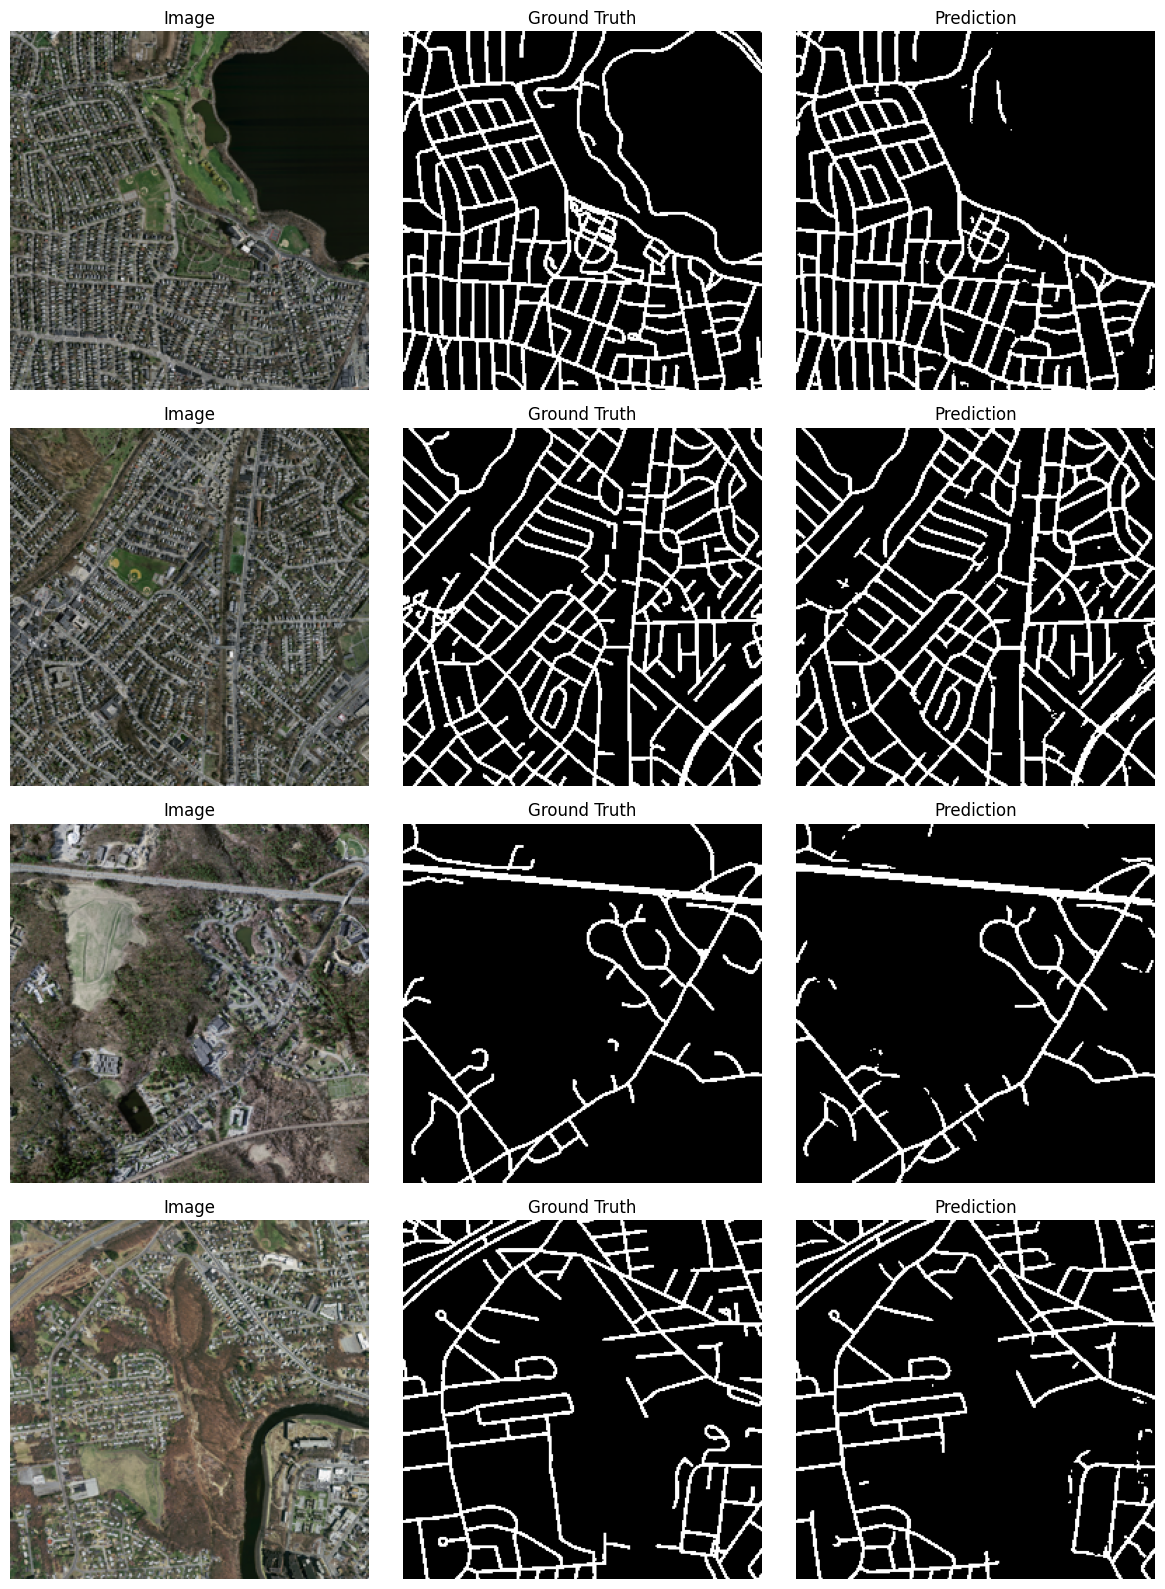

In [ ]:
MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def to_display_image(img, mean=MEAN, std=STD):
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()

    if img.ndim == 3 and img.shape[0] in (1, 3):
        img = np.transpose(img, (1, 2, 0))

    img = img.astype(np.float32)
    if img.ndim == 3 and img.shape[2] == 3:
        img = img * std + mean

    if img.max() <= 1.0 + 1e-6:
        img = img * 255.0

    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def visualize_image_mask_prediction(images, masks, predictions, n=5, mean=MEAN, std=STD):
    plt.figure(figsize=(12, 4 * n))
    for i in range(n):
        img = images[i]
        mask = masks[i]
        pred = predictions[i]

        if isinstance(mask, torch.Tensor):
            mask = mask.detach().cpu().numpy()
        if isinstance(pred, torch.Tensor):
            pred = pred.detach().cpu().numpy()

        if mask.ndim == 3 and mask.shape[0] == 1:
            mask = mask[0]
        if pred.ndim == 3 and pred.shape[0] == 1:
            pred = pred[0]

        pred_bin = (pred > 0.5).astype(np.uint8)

        plt.subplot(n, 3, 3 * i + 1)
        disp = to_display_image(img, mean, std)
        plt.imshow(disp)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(n, 3, 3 * i + 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(n, 3, 3 * i + 3)
        plt.imshow(pred_bin, cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

imgs, gt_masks = next(iter(val_loader))
imgs = imgs.to(device)
with torch.no_grad():
    preds = torch.sigmoid(unet(imgs))

visualize_image_mask_prediction(
    images=imgs.cpu(),
    masks=gt_masks.cpu(),
    predictions=preds.cpu(),
    n=4,
    mean=MEAN, std=STD
)